# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Сделаем импорт библиотек и необходимых функций:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker
import random

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.model_selection import PredefinedSplit
from sklearn.metrics import mean_squared_error
import warnings

Импортируем данные:

In [3]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

Cоздадим функцию для вывода общей информации о датафрейме и количества дубликатов:

In [4]:
def data_info(df):
    print ('Количество полных дубликатов в датасете:', sum(df.duplicated()))
    display(df.head())
    display(df.info())

Посмотрим информацию о каждом регионе:

In [5]:
data_info(geo_0)

Количество полных дубликатов в датасете: 0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [6]:
data_info(geo_1)

Количество полных дубликатов в датасете: 0


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

In [7]:
data_info(geo_2)

Количество полных дубликатов в датасете: 0


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

**Результаты предварительного анализа данных:**
<br>
- Пропуски и дубликаты отсутствуют в данных;  <br>
- Типы данных согласуются с их описанием: 1 качественный признак - идентификатор скважины, 4 признака - количественных;  <br>
- Датафрейм содержит 5 признаков и 100 тыс. объектов <br>

**Согласно условию задачи каждый датасет включает в себя следующие признаки:**<br>
- id - уникальный идентификатор скважины; <br>
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы); <br>
- product — объём запасов в скважине (тыс. баррелей). <br>

## Обучение и проверка модели

Зададим начальное значение для генерации последовательности псевдослучайных чисел


In [8]:
random = 12345

**Разобьем данные на обучающую и валидационную выборки в соотношении 75:25**

Список с датасетами данных по регионам:

In [9]:
geo = [geo_0, geo_1, geo_2]

Cписок с названиями датасетов:

In [10]:
geo_name = ['geo_0', 'geo_1', 'geo_2']

Cписок с обучающей и валидационной выборками:

In [11]:
train = []
valid = []

Cписок с признаками для обучающей и валидационной выборок:

In [12]:
features_train = []
features_valid = []

Cписок с целевыми признаками для обучающей и валидационной выборок:

In [13]:
target_train = []
target_valid = []

Зададим списки:

In [14]:
for region in geo:
    train_set, valid_set = train_test_split(region, test_size = 0.25, random_state = random)
    train.append(train_set)
    valid.append(valid_set)
    features_train_set = train_set.drop(['id','product'], axis = 1)
    features_valid_set = valid_set.drop(['id','product'], axis = 1)
    features_train.append(features_train_set)
    features_valid.append(features_valid_set)
    target_train_set = train_set['product']
    target_valid_set = valid_set['product']
    target_train.append(target_train_set)
    target_valid.append(target_valid_set)

Выведем доли и проведем проверку разделения:

In [15]:
for i in range(len(geo)):
    print('Датасет', geo_name[i])
    print('Доля тренировочной выборки равна: {:.1%}'.format(len(features_train[i])/ len(geo[i])))
    print('Доля валидационной выборки равна: {:.1%}'.format(len(features_valid[i])/ len(geo[i])))
    print('Размер датасета (число объектов):', len(geo[i]))
    print()

Датасет geo_0
Доля тренировочной выборки равна: 75.0%
Доля валидационной выборки равна: 25.0%
Размер датасета (число объектов): 100000

Датасет geo_1
Доля тренировочной выборки равна: 75.0%
Доля валидационной выборки равна: 25.0%
Размер датасета (число объектов): 100000

Датасет geo_2
Доля тренировочной выборки равна: 75.0%
Доля валидационной выборки равна: 25.0%
Размер датасета (число объектов): 100000



Проверка разделения выборок:

In [16]:
features_valid[0]

,f0,f1,f2
71751,0.948970,-0.057547,2.095727
80493,0.992974,0.206671,-0.142278
2655,1.199854,-0.563356,-1.852991
53233,0.691422,-0.433347,0.564974
91141,0.420772,0.972638,0.736190
...,...,...,...
12581,1.841106,-0.107678,2.585648
18456,0.041859,0.489280,2.168001
73035,0.376389,1.054298,-0.430104
63834,1.071330,-0.470046,4.527099


**Обучение, предсказание и расчет метрик.**


Список с предсказаниями на валидационной выборке:

In [17]:
predictions_valid = []

Cписок со средним предсказанным сырьем на валидационной выборке:

In [18]:
predicted_mean = []

**Зададим и обучим модель c помощью линейной регрессии. Затем выведем значение метрик MSE, RMSE и средних предсказанных значений:**

In [19]:
for i in range(len(geo)):
    regr = LinearRegression(normalize = True)
    regr.fit(features_train[i], target_train[i])
    product_pred = regr.predict(features_valid[i])
    product_pred = pd.Series(product_pred, index = features_valid[i].index)
    predictions_valid.append(product_pred)
    print('Регион', geo_name[i])
    mean = product_pred.mean()
    predicted_mean.append(mean)
    print('MSE: {:.2f}'.format(mean_squared_error(target_valid[i], product_pred)))
    print('RMSE: {:.2f}'.format(mean_squared_error(target_valid[i], product_pred)**0.5))
    print('Средний предсказанный запас сырья: {:.2f}'.format(mean))
    print()

Регион geo_0
MSE: 1412.21
RMSE: 37.58
Средний предсказанный запас сырья: 92.59

Регион geo_1
MSE: 0.80
RMSE: 0.89
Средний предсказанный запас сырья: 68.73

Регион geo_2
MSE: 1602.38
RMSE: 40.03
Средний предсказанный запас сырья: 94.97



Сделаем проверку сохранения предсказаний:

In [20]:
predictions_valid[0]

71751     95.894952
80493     77.572583
2655      77.892640
53233     90.175134
91141     70.510088
            ...    
12581    103.037104
18456     85.403255
73035     61.509833
63834    118.180397
43558    118.169392
Length: 25000, dtype: float64

**Анализ результатов**

Исходя из вышеперечисленных расчетов видно, что для региона geo_1 выходит наименьшая ошибка в предсказаниях, при этом RMSE меньше среднего предсказанного значения. Из этого можно сделать вывод о том, что для этого региона модель имеет хорошую точность прогноза. В то время как для других регионов (geo_0 и geo_2) значение RMSE сравнимо со средним предсказанным значением, т.е. модель дает значительную ошибку при предсказании запасов сырья для этих регионов.

# 3. Подготовка к расчёту прибыли

**Сохраним ключевые значения для расчетов в отдельных переменных.**

Число точек при разведке:

In [21]:
points_number = 500

Число наилучших точек:

In [22]:
points_best = 200


Бюджет в млрд. рублей:

In [23]:
budget = 10

Цена за баррель в рублях:

In [24]:
income_per_barrel = 450

Цена за тысячу баррелей (за единицу продукта) в тыс. рублей:

In [25]:
income_per_unit = 450

Вероятность убытков:

In [26]:
loss_probabilty = 0.025 

**Сохраним вспомогательные параметры для расчетов в отдельных переменных.**

Коэффициент пересчета млрд. рублей в рублей:

In [27]:
billions_ruble = 1E9 

Коэффициент пересчета тыс. рублей в рублей:

In [28]:
thousands_ruble = 1E3

Коэффициент пересчета рублей в млн. рублей:

In [29]:
ruble_millions = 1E-6

**Произведем расчет достаточного объёма сырья для безубыточной разработки новой скважины и сравним полученный объем сырья со средним запасом в каждом регионе.**

Рассчитаем бюджет разработки на одну скважину:

In [30]:
costs_per_well = budget *  billions_ruble / points_best

Рассчитаем необходимый объем продукта из бюджета разработки одной скважины:

In [31]:
product_volume = costs_per_well / (income_per_unit * thousands_ruble)
print('Необходимый объем продукта (в тыс. баррелей) {:.2f}'.format(product_volume))

Необходимый объем продукта (в тыс. баррелей) 111.11


In [32]:
for i in range(len(predicted_mean)):
    difference = predicted_mean[i] - product_volume
    relative = np.abs(difference / product_volume)
    print(geo_name[i])
    print('Абсолютная разница между средним предсказанным и необходимым объемом продукта {:.2f}' \
         .format(difference))
    print('Относительная разница между средним предсказанным и необходимым объемом продукта {:.2%}' \
         .format(relative))
    print()

geo_0
Абсолютная разница между средним предсказанным и необходимым объемом продукта -18.52
Относительная разница между средним предсказанным и необходимым объемом продукта 16.67%

geo_1
Абсолютная разница между средним предсказанным и необходимым объемом продукта -42.38
Относительная разница между средним предсказанным и необходимым объемом продукта 38.14%

geo_2
Абсолютная разница между средним предсказанным и необходимым объемом продукта -16.15
Относительная разница между средним предсказанным и необходимым объемом продукта 14.53%



**Ни один регион не дотягивает до точки безубыточности. В регионах  geo_0 и geo_2 относительная разница  составляет менее 20%, а в регионе geo_1 почти 40%. Видно, что нефтянке срочно нужны ребята DS с яндекс-практикума)) Поэтому при отборе скважин для разработки необходимо выбирать те, которые дают объем продукта выше среднего, при этом для региона geo_1 необходимо отбирать те скважины, которые значительно лучше средней по региону.**

# 4. Расчёт прибыли и рисков 

Расчет прибыли состоит из следующих этапов:
- выбора скважин с максимальными значениями предсказаний;    
- суммирование целевого значения объёма сырья, соответствующее этим предсказаниям;       
- расчет прибыли для полученного объёма сырья  

Создадим функцию для расчета прибыли по выбранным скважинам и предсказаниям модели. 

In [33]:
def Revenue(predictions, target, wells_number): #wells_number - число скважин
    predict = predictions.sort_values(ascending = False)
    selected = target[predict.index][:wells_number] 
    product_sum = selected.sum()#суммарный продукта для лучших скважин
    revenue_wells = product_sum * income_per_unit * thousands_ruble - budget * billions_ruble #прибыль с учетом полученного объёма сырья и расходов на разработку
    return selected, revenue_wells

Применение техники Bootstrap для нахождения распределения прибыли.

In [34]:
state = np.random.RandomState(random)

In [35]:
def RevenueBootstrap(predictions, target, wells_number, sample_size, region_name):
    values = []
    for j in range(1000): #проход по 1000 выборок и подсчет прибыли для каждой из них
        preds = predictions.sample(n = sample_size, replace = True, random_state=state)
        selected, rev = Revenue(preds, target, wells_number)
        values.append(rev)
        
    values = pd.Series(values) * ruble_millions #прибыль в млн. рублей
    
    lower = values.quantile(0.025) #границы 95% доверительного интервала
    upper = values.quantile(0.975)
    
    revenues_loss = values[values < 0] #вероятность убытков
    loss_probability = len(revenues_loss) / len(values) * 100
    
    mean_revenue = values.mean() #средняя прибыль
    
    #создание датафрейма с расчетными данными 
    data = pd.DataFrame(np.zeros((4,1)), index = ['2.5%', '97.5%', 'loss_prob', 'mean'], \
                        columns = [region_name])
    data.loc['2.5%',region_name] = lower
    data.loc['97.5%',region_name] = upper
    data.loc['loss_prob',region_name] = loss_probability 
    data.loc['mean', region_name] = mean_revenue 
    
    return values, data

Рассчитаем прибыль для трех регионов:

In [36]:
geo_data = []
geo_values = []

for i in range(len(geo)): 
    values, data = RevenueBootstrap(predictions_valid[i], target_valid[i], \
                                    points_best, points_number, geo_name[i])
    geo_values.append(values)
    geo_data.append(data)

Распределение прибыли по 1000 выборок и построим графики:

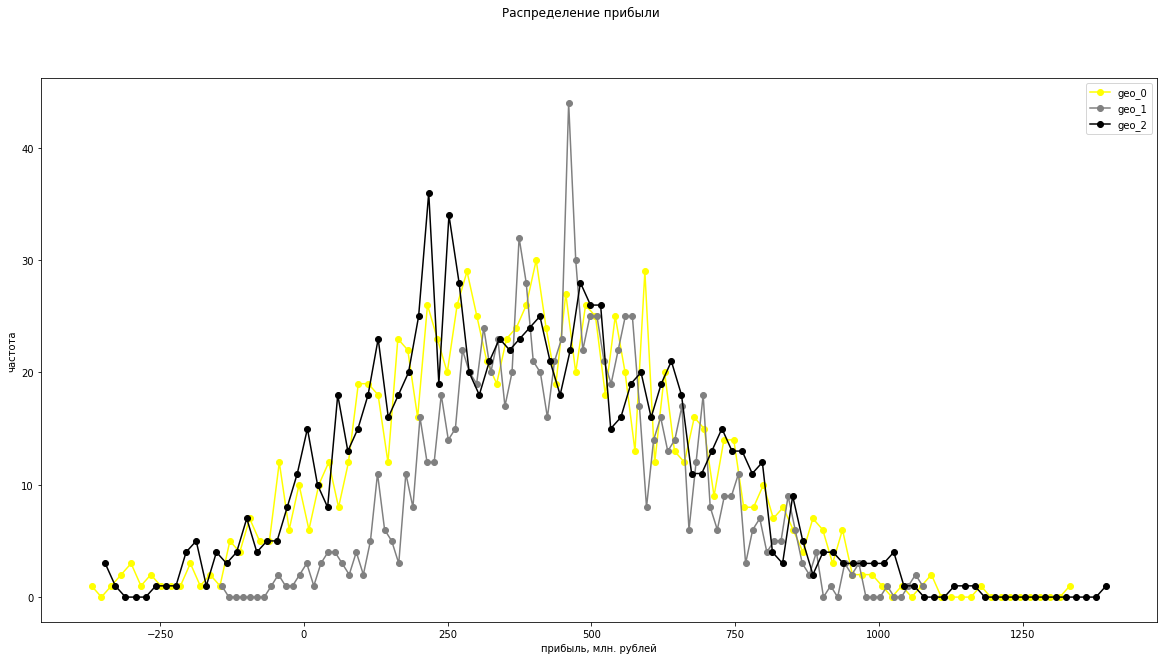

In [37]:
color = ['yellow', 'grey', 'black']
fig, axes = plt.subplots(1,1, figsize = (20,10))
plt.suptitle('Распределение прибыли');

for i in range(len(geo)):
    hist, bin_edges = np.histogram(geo_values[i], bins = 100)
    axes.plot(bin_edges[:-1], hist, marker = 'o', color = color[i]);
    axes.set_xlabel('прибыль, млн. рублей');
    axes.set_ylabel('частота');
    axes.legend(geo_name);

Из рисунка видно, что распределение прибыли для региона geo_1 сдвинуто вправо по отношению к распределениям прибыли для регионов geo_0 и geo_2. Это означает, что средняя прибыль для geo_1 должна быть больше, а риски убытков - меньше.

Сведем все данные в таблицу:

In [38]:
geo_data_pivot = pd.concat([geo_data[0], geo_data[1], geo_data[2]], axis=1, join='inner')
geo_data_pivot

,geo_0,geo_1,geo_2
2.5%,-111.215546,78.050811,-112.227625
97.5%,909.766942,862.952060,934.562915
loss_prob,6.900000,0.700000,6.500000
mean,396.164985,461.155817,392.950475


# 5. Вывод
Цель проекта - не просто построить прогноз по модели или прогноз продаж, а научиться выбирать лучшее управленческое решение на основе метода моделирования ситуации. В этом ключе мы как раз и применили технику Bootstrap.

Исходя из полученных данных и проведенного анализа, можно сделать следующий вывод:

- Регионы geo_0 и geo_2 - разработка слишком рискована, т.к. вероятность убытков больше 2,5%;
- Регион geo_1 - подходит для бурения, т.к. там самая высокая средняя прибыль и вероятность убытков меньше 2,5%